In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import re
import string

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from textblob import TextBlob

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
files=files.upload()

Saving mbti_1.csv to mbti_1.csv


In [3]:
df_copy = pd.read_csv('mbti_1.csv')

In [4]:
df_working = df_copy.copy()
df_working.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging


In [6]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [7]:
df_copy['code']=le.fit_transform(df_copy['type'])

In [8]:
df_copy.drop(['type'],axis=1,inplace=True)

In [29]:
X_Train, X_Test, y_Train, y_Test = train_test_split(df_copy['posts'].values,
                                                   df_copy['code'].values,
                                                   test_size=0.30, random_state=42)
print('X_Train ', X_Train.shape, '\n', 'X_Test ', X_Test.shape, '\n', 'y_Train ', y_Train.shape, '\n', 
      'y_Test', y_Test.shape)

X_Train  (6072,) 
 X_Test  (2603,) 
 y_Train  (6072,) 
 y_Test (2603,)


In [30]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
def cleaner(text):
    #wordnet = WordNetLemmatizer()  
    stemmer=PorterStemmer()                                      # groups words having the same stems
    text = text.replace('|||', ' ')                                  # replaces post separators with empty space
    text = re.sub(r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', text, flags=re.MULTILINE)  # replace hyperlink with 'URL'
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))      # removes digits
    text = text.lower().strip()                                      # convert to lower case
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [12]:
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp',
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
stop = stopwords.words('english')

for type in types:
    stop.append(type)
stop.append("url")
stop_rev = stop    
print(stop_rev)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
pipeline_preprocessing = make_pipeline(
   TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=200))

X_Train = pipeline_preprocessing.fit_transform(X_Train)
X_Test = pipeline_preprocessing.transform(X_Test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [33]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='minority')
x,y=smote.fit_sample(X_Train, y_Train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout,GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Model
from tensorflow.math import confusion_matrix

In [35]:
model = Sequential(
    [Dense(100, input_shape=(200,),activation='relu'),
    Dropout(0.5),
    Dense(60, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='sigmoid')]
)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(X_Train, y_Train, epochs = 500,batch_size=128)

Epoch 1/500
48/48 [==============================] - 1s 3ms/step - loss: 2.6968 - acc: 0.1479
Epoch 2/500
48/48 [==============================] - 0s 3ms/step - loss: 2.3666 - acc: 0.2083
Epoch 3/500
48/48 [==============================] - 0s 3ms/step - loss: 2.2957 - acc: 0.2013
Epoch 4/500
48/48 [==============================] - 0s 3ms/step - loss: 2.2246 - acc: 0.2408
Epoch 5/500
48/48 [==============================] - 0s 3ms/step - loss: 2.1626 - acc: 0.2663
Epoch 6/500
48/48 [==============================] - 0s 3ms/step - loss: 2.1128 - acc: 0.2752
Epoch 7/500
48/48 [==============================] - 0s 3ms/step - loss: 2.0756 - acc: 0.3043
Epoch 8/500
48/48 [==============================] - 0s 3ms/step - loss: 2.0199 - acc: 0.3111
Epoch 9/500
48/48 [==============================] - 0s 3ms/step - loss: 1.9724 - acc: 0.3347
Epoch 10/500
48/48 [==============================] - 0s 3ms/step - loss: 1.9799 - acc: 0.3313
Epoch 11/500
48/48 [==============================] - 0s 3m

In [36]:
model.evaluate(X_Test,y_Test)

82/82 [==============================] - 0s 2ms/step - loss: 4.9246 - acc: 0.3192


[4.92463493347168, 0.3192470371723175]

In [39]:
y_pred=model.predict(X_Test)

In [41]:
y_pred=[np.argmax(i) for i in y_pred]

In [42]:
cm=confusion_matrix(labels=y_Test,predictions=y_pred)
cm

<tf.Tensor: shape=(16, 16), dtype=int32, numpy=
array([[  2,   5,   1,   1,   0,   0,   0,   0,  20,  17,   5,   2,   3,
          0,   0,   0],
       [  2,  42,   3,  14,   0,   0,   0,   1,  36,  63,  12,  14,   1,
          7,   0,   1],
       [  1,   3,   5,  10,   0,   0,   0,   0,   8,   7,  11,   9,   0,
          0,   1,   3],
       [  0,  13,   4,  29,   0,   0,   0,   1,  21,  41,  29,  52,   0,
          2,   5,   4],
       [  1,   1,   0,   0,   0,   0,   0,   0,   2,   4,   0,   1,   0,
          1,   0,   0],
       [  0,   2,   0,   1,   0,   0,   0,   0,   1,   2,   2,   0,   0,
          0,   1,   0],
       [  0,   1,   1,   1,   0,   0,   0,   0,   4,   3,   3,   2,   0,
          1,   0,   1],
       [  0,   1,   1,   6,   0,   0,   0,   2,   0,   4,   3,   8,   0,
          0,   0,   0],
       [  4,  26,   5,  11,   0,   0,   0,   1, 151, 142,  38,  40,   3,
          7,   3,   3],
       [  5,  34,   2,  11,   0,   1,   0,   2, 122, 287,  34,  47,   1,
      

In [49]:
cl=classification_report(y_Test,y_pred)
print(cl)

              precision    recall  f1-score   support

           0       0.09      0.04      0.05        56
           1       0.27      0.21      0.24       196
           2       0.12      0.09      0.10        58
           3       0.20      0.14      0.17       201
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        17
           7       0.29      0.08      0.12        25
           8       0.30      0.35      0.32       434
           9       0.39      0.51      0.44       566
          10       0.32      0.41      0.36       311
          11       0.35      0.40      0.37       404
          12       0.18      0.03      0.06        61
          13       0.14      0.08      0.11        84
          14       0.13      0.06      0.08        70
          15       0.21      0.08      0.11       101

    accuracy                           0.32      2603
   macro avg       0.19   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
le.classes_

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [44]:
cm_rfc = np.array(cm)

cm = pd.DataFrame(cm_rfc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])
cm

,predict_ENFJ,predict_ENFP,predict_ENTJ,predict_ENTP,predict_ESFJ,predict_ESFP,predict_ESTJ,predict_ESTP,predict_INFJ,predict_INFP,predict_INTJ,predict_INTP,predict_ISFJ,predict_ISFP,predict_ISTJ,predict_ISTP
ENFJ,2,5,1,1,0,0,0,0,20,17,5,2,3,0,0,0
ENFP,2,42,3,14,0,0,0,1,36,63,12,14,1,7,0,1
ENTJ,1,3,5,10,0,0,0,0,8,7,11,9,0,0,1,3
ENTP,0,13,4,29,0,0,0,1,21,41,29,52,0,2,5,4
ESFJ,1,1,0,0,0,0,0,0,2,4,0,1,0,1,0,0
ESFP,0,2,0,1,0,0,0,0,1,2,2,0,0,0,1,0
ESTJ,0,1,1,1,0,0,0,0,4,3,3,2,0,1,0,1
ESTP,0,1,1,6,0,0,0,2,0,4,3,8,0,0,0,0
INFJ,4,26,5,11,0,0,0,1,151,142,38,40,3,7,3,3
INFP,5,34,2,11,0,1,0,2,122,287,34,47,1,13,3,4


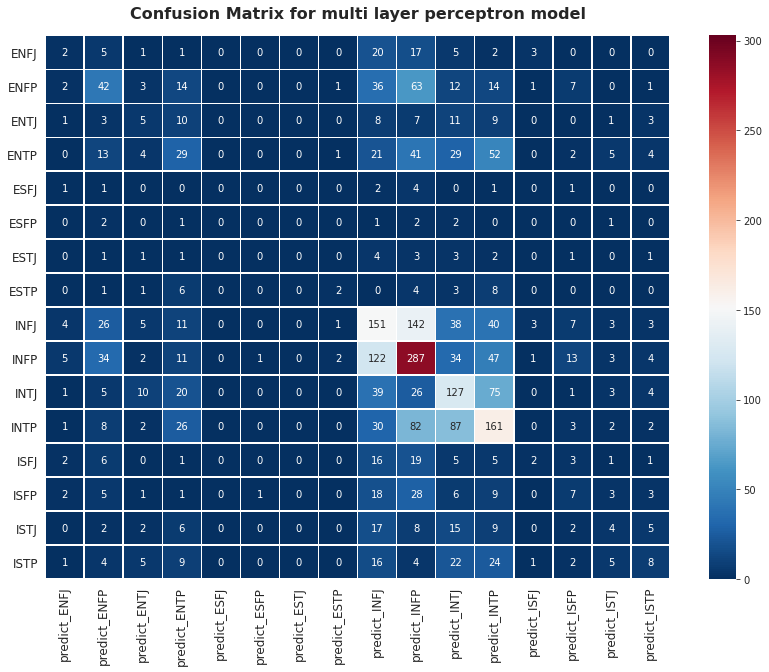

In [45]:
# Create confusion matrix heatmap of mlp model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for multi layer perceptron model', fontsize=16,
          fontweight='bold', y=1.02)
sns.heatmap(cm, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

In [ ]:
# Determine baseline for each of the four axes
baseline_IE = df_working['I-E'].value_counts().max() / df_working['I-E'].value_counts().sum()
baseline_NS = df_working['N-S'].value_counts().max() / df_working['N-S'].value_counts().sum()
baseline_TF = df_working['T-F'].value_counts().max() / df_working['T-F'].value_counts().sum()
baseline_JP = df_working['J-P'].value_counts().max() / df_working['J-P'].value_counts().sum()

print('Introversion - Extroversion: ', baseline_IE)
print('Intuition - Sensing: ', baseline_NS)
print('Thinking - Feeling: ', baseline_TF)
print('Judging - Perceiving: ', baseline_JP)

Introversion - Extroversion:  0.7695677233429394
Intuition - Sensing:  0.8620172910662824
Thinking - Feeling:  0.5410951008645534
Judging - Perceiving:  0.604149855907781


In [ ]:
# Introversion - Extroversion
X_train_IE, X_test_IE, y_train_IE, y_test_IE = train_test_split(df_working['posts'].values,
                                                   df_working['I-E'].values,
                                                   test_size=0.30, random_state=42)
# Intuition - Sensing
X_train_NS, X_test_NS, y_train_NS, y_test_NS = train_test_split(df_working['posts'].values,
                                                   df_working['N-S'].values,
                                                   test_size=0.30, random_state=42)
# Thinking - Feeling
X_train_TF, X_test_TF, y_train_TF, y_test_TF = train_test_split(df_working['posts'].values,
                                                   df_working['T-F'].values,
                                                   test_size=0.30, random_state=42)
# Judging - Perceiving
X_train_JP, X_test_JP, y_train_JP, y_test_JP = train_test_split(df_working['posts'].values,
                                                   df_working['J-P'].values,
                                                   test_size=0.30, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


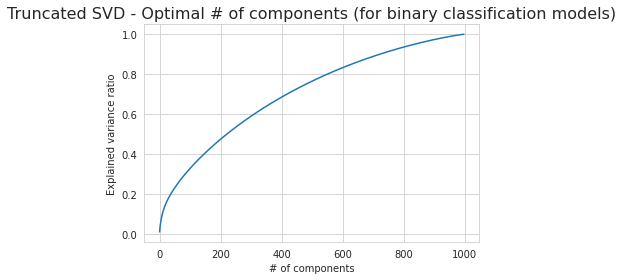

In [ ]:
cv = TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit(X_train_IE)
X_train_IE_cv = cv.transform(X_train_IE)

# Use max components and graph the explained variance ratio to find cutoff point 
tsvd = TruncatedSVD(n_components=999)
tsvd.fit(X_train_IE_cv)
plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title("Truncated SVD - Optimal # of components (for binary classification models)", fontsize=16)
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio");


In [ ]:
pipeline_preprocessing2 = make_pipeline(
    CountVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=200))

In [ ]:
# Preprocess each of the train-test splits
# Introversion - Extroversion
X_train_IE_tsvd = pipeline_preprocessing2.fit_transform(X_train_IE)
X_test_IE_tsvd = pipeline_preprocessing2.transform(X_test_IE)

# Intuition - Sensing
X_train_NS_tsvd = pipeline_preprocessing2.fit_transform(X_train_NS)
X_test_NS_tsvd = pipeline_preprocessing2.transform(X_test_NS)

# Thinking - Feeling
X_train_TF_tsvd = pipeline_preprocessing2.fit_transform(X_train_TF)
X_test_TF_tsvd = pipeline_preprocessing2.transform(X_test_TF)

# Judging - Perceiving
X_train_JP_tsvd = pipeline_preprocessing2.fit_transform(X_train_JP)
X_test_JP_tsvd = pipeline_preprocessing2.transform(X_test_JP)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
sm = SMOTE()
Xsm_train_IE_tsvd, ysm_train_IE = sm.fit_sample(X_train_IE_tsvd, y_train_IE)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
ysm_train_IE

array(['Introversion', 'Introversion', 'Introversion', ...,
       'Extroversion', 'Extroversion', 'Extroversion'], dtype=object)

In [ ]:
ysm_train_IE=le.fit_transform(ysm_train_IE)

In [ ]:
ysm_train_IE

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
model = Sequential(
    [Dense(100, input_shape=(200,),activation='relu'),
    Dropout(0.5),
    Dense(60, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')]
)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(Xsm_train_IE_tsvd, ysm_train_IE, epochs = 100,batch_size=128)

Epoch 1/100
73/73 [==============================] - 1s 3ms/step - loss: 1.5945 - acc: 0.5073
Epoch 2/100
73/73 [==============================] - 0s 3ms/step - loss: 0.8147 - acc: 0.5226
Epoch 3/100
73/73 [==============================] - 0s 3ms/step - loss: 0.7093 - acc: 0.5475
Epoch 4/100
73/73 [==============================] - 0s 3ms/step - loss: 0.6928 - acc: 0.5706
Epoch 5/100
73/73 [==============================] - 0s 3ms/step - loss: 0.6775 - acc: 0.5946
Epoch 6/100
73/73 [==============================] - 0s 3ms/step - loss: 0.6537 - acc: 0.6267
Epoch 7/100
73/73 [==============================] - 0s 3ms/step - loss: 0.6320 - acc: 0.6465
Epoch 8/100
73/73 [==============================] - 0s 3ms/step - loss: 0.6201 - acc: 0.6648
Epoch 9/100
73/73 [==============================] - 0s 3ms/step - loss: 0.5946 - acc: 0.6958
Epoch 10/100
73/73 [==============================] - 0s 3ms/step - loss: 0.5746 - acc: 0.7051
Epoch 11/100
73/73 [==============================] - 0s 3m

In [ ]:
y_test_IE=le.fit_transform(y_test_IE)

In [ ]:
model.evaluate(X_test_IE_tsvd,y_test_IE)

82/82 [==============================] - 0s 2ms/step - loss: 3.0819 - acc: 0.7630


[3.081878662109375, 0.7629657983779907]

In [ ]:
y_pred_IE=model.predict(X_test_IE_tsvd)

In [ ]:
y_pred_IE=[np.argmax(i) for i in y_pred_IE]

In [ ]:
cm=confusion_matrix(labels=y_test_IE,predictions=y_pred_IE)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[  80,  492],
       [ 125, 1906]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

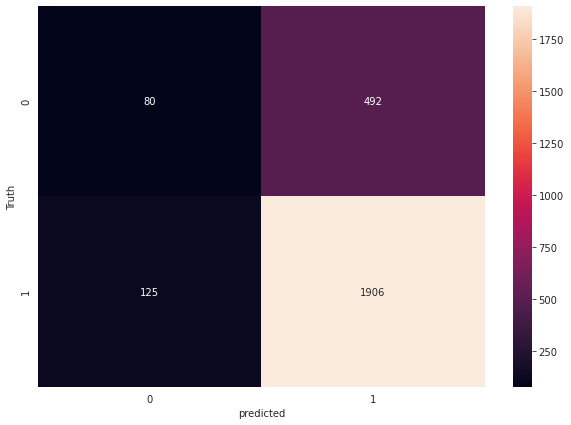

In [ ]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test_IE, y_pred_IE))

              precision    recall  f1-score   support

           0       0.39      0.14      0.21       572
           1       0.79      0.94      0.86      2031

    accuracy                           0.76      2603
   macro avg       0.59      0.54      0.53      2603
weighted avg       0.71      0.76      0.72      2603



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0883 - acc: 0.9739
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0955 - acc: 0.9721
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0835 - acc: 0.9744
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0883 - acc: 0.9759
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0859 - acc: 0.9748
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0841 - acc: 0.9766
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0766 - acc: 0.9775
Epoch 8/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0831 - acc: 0.9776
Epoch 9/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0740 - acc: 0.9798
Epoch 10/100
83/83 [==============================] - 0s 3ms/step - loss: 0.0789 - acc: 0.9781
Epoch 11/100
83/83 [==============================] - 0s 3m

Text(69.0, 0.5, 'Truth')

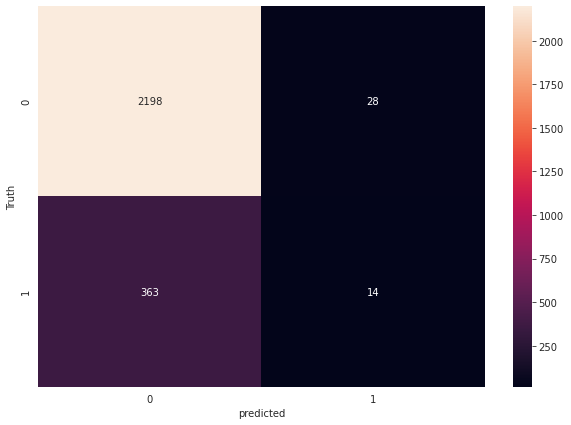

In [ ]:
sm = SMOTE()
Xsm_train_NS_tsvd, ysm_train_NS = sm.fit_sample(X_train_NS_tsvd, y_train_NS)
ysm_train_NS=le.fit_transform(ysm_train_NS)

history = model.fit(Xsm_train_NS_tsvd, ysm_train_NS, epochs = 100,batch_size=128)
y_test_NS=le.fit_transform(y_test_NS)
model.evaluate(X_test_NS_tsvd,y_test_NS)
y_pred_NS=model.predict(X_test_NS_tsvd)
y_pred_NS=[np.argmax(i) for i in y_pred_NS]


In [ ]:
model.evaluate(X_test_NS_tsvd,y_test_NS)

82/82 [==============================] - 0s 2ms/step - loss: 1.6519 - acc: 0.8498


[1.6518661975860596, 0.8497887253761292]

In [ ]:
cm=confusion_matrix(labels=y_test_NS,predictions=y_pred_NS)
print(cm)


tf.Tensor(
[[2198   28]
 [ 363   14]], shape=(2, 2), dtype=int32)


In [ ]:
print(classification_report(y_test_NS, y_pred_NS))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2226
           1       0.33      0.04      0.07       377

    accuracy                           0.85      2603
   macro avg       0.60      0.51      0.49      2603
weighted avg       0.78      0.85      0.79      2603



In [ ]:
sm = SMOTE()
Xsm_train_TF_tsvd, ysm_train_TF = sm.fit_sample(X_train_TF_tsvd, y_train_TF)
ysm_train_TF=le.fit_transform(ysm_train_TF)

history = model.fit(Xsm_train_TF_tsvd, ysm_train_TF, epochs = 100,batch_size=128)
y_test_TF=le.fit_transform(y_test_TF)
model.evaluate(X_test_TF_tsvd,y_test_TF)
y_pred_TF=model.predict(X_test_TF_tsvd)
y_pred_TF=[np.argmax(i) for i in y_pred_TF]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
52/52 [==============================] - 0s 3ms/step - loss: 2.4683 - acc: 0.5366
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 0.9526 - acc: 0.5653
Epoch 3/100
52/52 [==============================] - 0s 3ms/step - loss: 0.8114 - acc: 0.5915
Epoch 4/100
52/52 [==============================] - 0s 3ms/step - loss: 0.7323 - acc: 0.6156
Epoch 5/100
52/52 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.6258
Epoch 6/100
52/52 [==============================] - 0s 3ms/step - loss: 0.6561 - acc: 0.6475
Epoch 7/100
52/52 [==============================] - 0s 3ms/step - loss: 0.6305 - acc: 0.6631
Epoch 8/100
52/52 [==============================] - 0s 3ms/step - loss: 0.6183 - acc: 0.6699
Epoch 9/100
52/52 [==============================] - 0s 3ms/step - loss: 0.5852 - acc: 0.7013
Epoch 10/100
52/52 [==============================] - 0s 3ms/step - loss: 0.5755 - acc: 0.7018
Epoch 11/100
52/52 [==============================] - 0s 3m

In [ ]:
model.evaluate(X_test_TF_tsvd,y_test_TF)

82/82 [==============================] - 0s 2ms/step - loss: 1.0841 - acc: 0.6892


[1.0841354131698608, 0.689204752445221]

In [ ]:
cm=confusion_matrix(labels=y_test_TF,predictions=y_pred_TF)
print(cm)

tf.Tensor(
[[1219  197]
 [ 612  575]], shape=(2, 2), dtype=int32)


Text(69.0, 0.5, 'Truth')

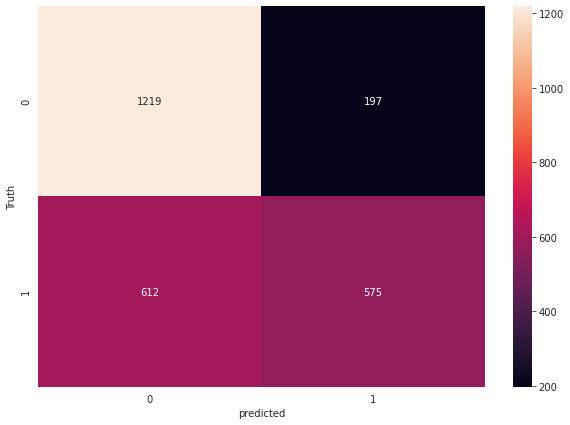

In [ ]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test_TF, y_pred_TF))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75      1416
           1       0.74      0.48      0.59      1187

    accuracy                           0.69      2603
   macro avg       0.71      0.67      0.67      2603
weighted avg       0.70      0.69      0.68      2603



In [ ]:
sm = SMOTE()
Xsm_train_JP_tsvd, ysm_train_JP = sm.fit_sample(X_train_JP_tsvd, y_train_JP)
ysm_train_JP=le.fit_transform(ysm_train_JP)

history = model.fit(Xsm_train_JP_tsvd, ysm_train_JP, epochs = 100,batch_size=128)
y_test_JP=le.fit_transform(y_test_JP)
model.evaluate(X_test_JP_tsvd,y_test_JP)
y_pred_JP=model.predict(X_test_JP_tsvd)
y_pred_JP=[np.argmax(i) for i in y_pred_JP]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3680 - acc: 0.8179
Epoch 2/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3703 - acc: 0.8174
Epoch 3/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3724 - acc: 0.8130
Epoch 4/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3617 - acc: 0.8222
Epoch 5/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3688 - acc: 0.8144
Epoch 6/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3696 - acc: 0.8202
Epoch 7/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3557 - acc: 0.8192
Epoch 8/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3603 - acc: 0.8212
Epoch 9/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3580 - acc: 0.8246
Epoch 10/100
58/58 [==============================] - 0s 3ms/step - loss: 0.3508 - acc: 0.8248
Epoch 11/100
58/58 [==============================] - 0s 3m

82/82 [==============================] - 0s 2ms/step - loss: 2.4199 - acc: 0.5328
[2.4199066162109375, 0.5328466892242432]
_____
tf.Tensor(
[[624 393]
 [823 763]], shape=(2, 2), dtype=int32)
_____
_____
              precision    recall  f1-score   support

           0       0.43      0.61      0.51      1017
           1       0.66      0.48      0.56      1586

    accuracy                           0.53      2603
   macro avg       0.55      0.55      0.53      2603
weighted avg       0.57      0.53      0.54      2603



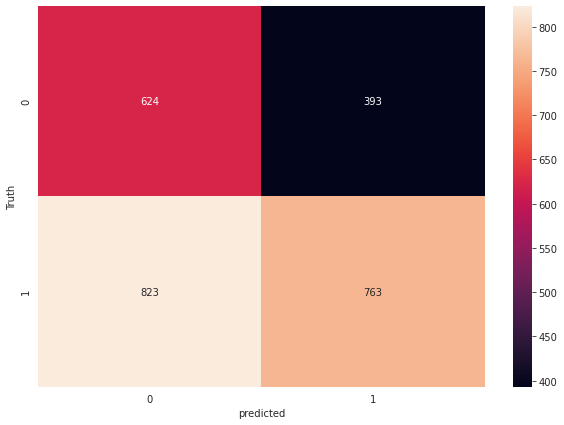

In [ ]:
print(model.evaluate(X_test_JP_tsvd,y_test_JP))
print("_____")
cm=confusion_matrix(labels=y_test_JP,predictions=y_pred_JP)
print(cm)
print("_____")
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')
print("_____")
print(classification_report(y_test_JP, y_pred_JP))